# The classic pearson correlation 

Pearson correlation in its simplest form measures the linear relationship between two random variables. 

The sample pearson correlation for rnadom variables $(x,y)$ is calculated as:

\begin{align*}
\Large r = \frac{\Sigma(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\Sigma(x_i - \bar{x})^2 \Sigma(y_i - \bar{y})^2}}\end{align*}


Under the NHST framework the p-value is calculated under the t-distribution:

\begin{align*}
\large t = \frac{r\sqrt{n-2}}{\sqrt{1 - r^2}}
\end{align*}

$$ \large H_0: r = \rho_0$$
$$ \large H_1: r \neq \rho_0$$

# Bayesian inference

<font size = "3"> Following the quick description of the classic pearson correlation above its important to keep in mind that Bayesian inferences are all derived from the application of Bayes rule $$P(\theta \mid y) = \large \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$$ and as such while the following description of the Bayesian model is an equivalent to the Pearson correlation, it is fundamentally different, because it uses fully probabilistic modelling and the inferences are not based on sampling distributions</font>
    
<font size = "1"> For a fuller description see the Practicing Bayesian statistics markdown file within the Github repository.</font>

## Bayesian correlation comes in many flavours

The following models, like many Bayesian models, can be parameterized in multiple ways to yield the same inferences. For models used to calculate correlations, a good resource to explore this variation in parameterization is this [great blog](https://solomonkurz.netlify.app/blog/2019-02-16-bayesian-correlations-let-s-talk-options/) by the fantastic Bayesian/apllied stats educator Solomon Kurz. That blog focus on using regressionm modelling framewrok thorugh use of the Paul Buerkner's R brms package to estiamte correlations.

That blog focuses on using a regression modeling framework through Paul Bürkner's R brms package to estimate correlations.

This notebook focuses on a specific form of one of the parameterizations of a model to estimate correlations (specifically multivariate normal models with fixed known 
μ's and σ's) and ignores much of the regression framework nomenclature from a probabilistic modeling perspective. (Readers, please note that this is more an issue of semantics than substance, as much of the mathematics overlaps, which is why regression-focused software such as brms can estimate correlation models when specified correctly, as demonstrated by Solomon.)

This parameterisation is chosen because it is the most efficient implementation (however, see the repository for all model implementations). The code here is simpler than the Stan code produced by the brms package used in the blog to achieve the same results for the data analysed here. Hopefully, this will aid individuals learning Stan code in better understanding the implementation process.

# Steps of Bayesian data analysis

<font size = "3"> Kruschke (2015) offers a step by step formulation for how to conduct a Bayesian data analysis:

1. Identify the relevant data for question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. In the case of scientific research publication is the goal, as such the priors must be accepted by a skeptical audience. Much of this can be achieved using prior predcitve checks to acsetain os the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then interpret the posterior

5. Conduct model checks. i.e. Posterior predcitive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

In [1]:
# Import data analysis and visualisation packages
%matplotlib inline
import stan as ps
import numpy as np
import pandas as pd
import patsy as pt
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply();

# Specify the number of chains to the number of availible cpu's.
n_chains = os.cpu_count()
n_samples = 2000
#Convert to int so Stan will not crash below.
n_warmup = int(n_samples/2)
#Specify step size.
stepS = .8

## Step 1 - Identify the relevant data for the question under investigation

Due to the simple nature of correlations the datset chosen here as demonstrative example is the mtcars dataset. This dataset is a common pedagological dataset in the statistics and machine learning circles.The dataset description in full can be found at https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/mtcars. A short descrition is simple that the dataset was extracted from 1974 Motor Trend US magazine. Reporting automotive perfomance metrics across a range of automobiles.

In [ ]:
# Dataset taken from open github repository
url = 

# Import data into pandas dataframe.
df = pd.read_csv(url)

# Step 2 - Define the descriptive statistical model

$$
\begin{align*}
y_{ij} &\sim \text{MultivariateNormal}(\mu_k, \Sigma) \\
\mu_k &= [0,0] \\
\sigma_k &= [1,1] \\
\rho &\sim \text{LKJ}(1) \\
\Sigma &\sim MVN\bigg(\mu_k, 
\begin{bmatrix}
\sigma_1^2 & \rho \sigma_1 \sigma_2 \\
\rho \sigma_1 \sigma_2 & \sigma_2^2 
\end{bmatrix}\bigg)
\end{align*}
$$


As stated above the model above allows for the estimation of correlation between variables similarly to classic Pearson correlation. The biggest difference here though is because we are only interested in the correlations we can standardise the data and then assume that the $\mu's$ & $\sigma's$ are known in the model (as 0 and 1 repectively) as they are not of interest in this case whilst still preserving the same covariance in the data to estimate correlation between the variables of interest. This method becomes more valuable as the number of correlations you wish to estimate increases as it greatly reduces the number of parameters that are needed to be estimated and allows for more stable computation.

# Step 4 - use Bayes rule

# Stan model for multiple correlation estimation

In [3]:
Correlation_model = """
data{

int<lower = 0> N; // Number of data points
int<lower = 0> K; // Number of correlates
vector[K] y[N]; // vectorised form of matrix

// Assumed know parameter values
vector[K] mu;
vector[K] sigma;

}

parameters{
// Correlation matrix
corr_matrix[K] rho;
}

model{
// Covariance matrix
matrix[K,K] Sigma;
Sigma = quad_form_diag(rho,sigma);

// Uniform prior for correlation parameters
rho ~ lkj_corr(1);

//Likelihood
y ~ multi_normal(mu, Sigma);
}   
"""

In [5]:
# Generate Python dicitonary to pass to Stan data block with relevant variables.
data = {'N': len(y),
       "K": y.shape[1],
       'y': y,
       'mu': np.repeat(0,y.shape[1]),
        'sigma': np.repeat(1,y.shape[1])}

In [6]:
# Compile stan model to C++ code.
sm = ps.build(Correlation_model, data = data, random_seed = 1)

Building...



Building: 64.8s, done.Messages from stanc:
Warning in '/tmp/httpstan_eh4dh0ex/model_fptdn4n6.stan', line 25, column 0: It is suggested to reparameterize your model to replace lkj_corr with lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run slower, consume more memory, and has higher risk of numerical errors.


In [7]:
fit = sm.sample(num_chains = n_chains , num_samples = n_samples, num_warmup = n_warmup, stepsize = stepS)

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.000118 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.18 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lkj_corr_lpdf: y is not positive definite. (in '/tmp/httpstan_6eqr4zc7/model_fptdn4n6.stan', line 25, column 0 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lkj_corr_lpdf

In [8]:
# Output summary plot for estimated correltation parameters
az.summary(fit)

/home/users/bu807041/.local/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"rho[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"rho[0,1]",-0.849,0.041,-0.917,-0.774,0.001,0.001,2586.0,3199.0,1.0
"rho[1,0]",-0.849,0.041,-0.917,-0.774,0.001,0.001,2586.0,3199.0,1.0
"rho[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,8023.0,8000.0,1.0


In [9]:
# Put samples into to pandas dataframe and calcualte key metrics
fit_df = fit.to_frame()

## Step 5 - Posterior predictive checks

For this correlation model some of these checks make less sense, because implicitly many of the parameters are assumed to be known as 0 or 1, and we are only interested to how much the variables are correlated. However, posterior checks to see if posterior samples have no pathological issues is still crucial.

## Posterior

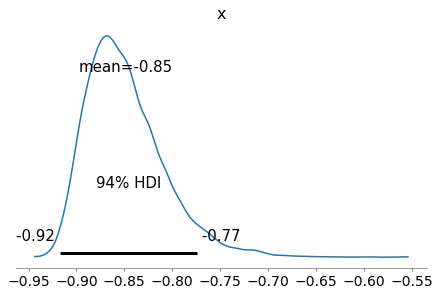

In [10]:
# Plot the single correlation coefficent of interest.
az.plot_posterior(fit_df['rho.2.1'].values);

## Traceplot

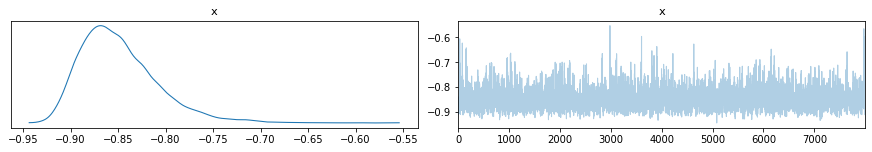

In [11]:
az.plot_trace(fit_df['rho.2.1'].values);

Traceplot shows no pathlogical issue with good chain mixing 'Fuzzy caterpillars'

## Autocorrelation plot

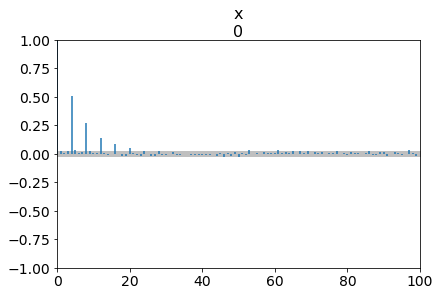

In [12]:
az.plot_autocorr(fit_df['rho.2.1'].values);

Autocorrelation plot suggests no major issues with autocorrelation quickly returning to 0.

# Reporting the results of the Bayesian correlation

<font size = "3">As Kruschke (2015) correctly points out there is no standard formula for presentation of results of Bayesian data analysis in journal articles like the APA guide for reporting frequentist analysis. It is likely there never will be, because as McElreath (2020) explains, Bayesian data analysis is more like a engineering approach to the problem and the resulting model that is fit will be analysis specific. In addition, as Gabry et al, (2019) argue visualisations maybe even more key for describing an analysis (show dont tell). As such, all the visualisations used above would likely be included with any write up. Anyhow, the write up below generally follows the advice of Kruschke (2015) chapter 25. In any application though it comes down to the problem to be described and the audience that needs to be convinced. </p><br/>

<h2>Write up</h2><br/>

# References

Bürkner, P. C. (2017). brms: An R package for Bayesian multilevel models using Stan. Journal of statistical software, 80(1), 1-28.

McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan. Boca Raton: CRC Press.

Vehtari, A., Gelman, A., Simpson, D., Carpenter, B., & Bürkner, P. C. (2019). Rank-normalization, folding, and localization: An improved $\widehat {R} $ for assessing convergence of MCMC. arXiv preprint arXiv:1903.08008.